In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Transform: normlize images between [-1, 1] (because Tanh will be used at output)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='.data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.28MB/s]


In [3]:
class Generator(nn.Module):
  def __init__(self, noise_dim, img_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(noise_dim, 256),
        nn.ReLU(True),
        nn.Linear(256, 512),
        nn.ReLU(True),
        nn.Linear(512, 1024),
        nn.ReLU(True),
        nn.Linear(1024, img_dim),
        nn.Tanh()          # Becuase we normalized images to [-1, 1]
    )

  def forward(self, z):
    return self.model(z)

# This Generator is a simple multi-layer perceptron (MLP) that will learn to
# transform random noise into images that look like the training data.

In [4]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(img_dim, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
        nn.Sigmoid()   # Output probability between 0 and 1
    )

    # The final activation function. It squashes the output value to be between
    # 0 and 1, representing the probability that the input image is real
    # (closer to 1 means real, closer to 0 means fake).


  def forward(self, img):
    return self.model(img)

# This Discriminator is a simple multi-layer perceptron (MLP) that will learn
# to distinguish between real images from the training dataset and fake images
# generated by the Generator.

In [10]:
def show_generated_image(epoch, generator, fixed_noise):
  generator.eval()
  with torch.no_grad():
    fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
    fake_imgs = fake_imgs*0.5 + 0.5

  grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
  plt.figure(figsize=(8,8))
  plt.imshow(grid.permute(1,2,0).cpu().numpy())
  plt.title(f'Generated Images at Epoch {epoch}')
  plt.axis('off')
  plt.show()
  generator.train()

In [17]:
noise_dim = 100
img_dim = 28*28

# Models
generator = Generator(noise_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
criterion = nn.BCELoss()

In [20]:
def train_gen(train_loader, num_epochs, mode='one_one'):
  fixed_noise = torch.randn(64, noise_dim).to(device)

  for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
      batch_size = real.size(0)
      real = real.view(batch_size, -1).to(device)

      ### Create real and fake labels
      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      #################################################
      #             Train Discriminator               #
      #################################################

      # Real images
      outputs = discriminator(real)
      d_loss_real = criterion(outputs, real_labels)
      real_score = outputs

      # Fake images
      z = torch.randn(batch_size, noise_dim).to(device)
      fake = generator(z)
      outputs = discriminator(fake.detach()) # detach so gradients don't flow into genrator
      d_loss_fake = criterion(outputs, fake_labels)
      fake_score = outputs

      # Total discriminator loss
      d_loss = d_loss_real + d_loss_fake

      discriminator.zero_grad()
      d_loss.backward()
      d_optimizer.step()

      #################################################
      #             Train Generator                   #
      #################################################

      # Generate fake images again
      z = torch.randn(batch_size, noise_dim).to(device)
      fake = generator(z)
      outputs = discriminator(fake)

      # Calculate generator loss
      g_loss = criterion(outputs, real_labels) # trick duscriminator

      # Backprop and optimize
      generator.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')
      show_generated_image(epoch+1, generator, fixed_noise)

Training: 1-step Gen, 1-step Disc
Epoch [10/50], D_loss: 1.0287, G_loss: 2.8269


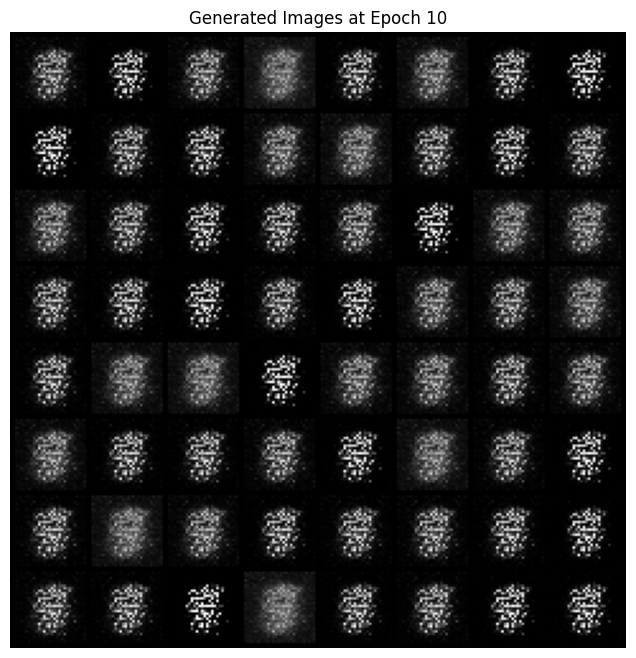

Epoch [20/50], D_loss: 0.6792, G_loss: 3.3931


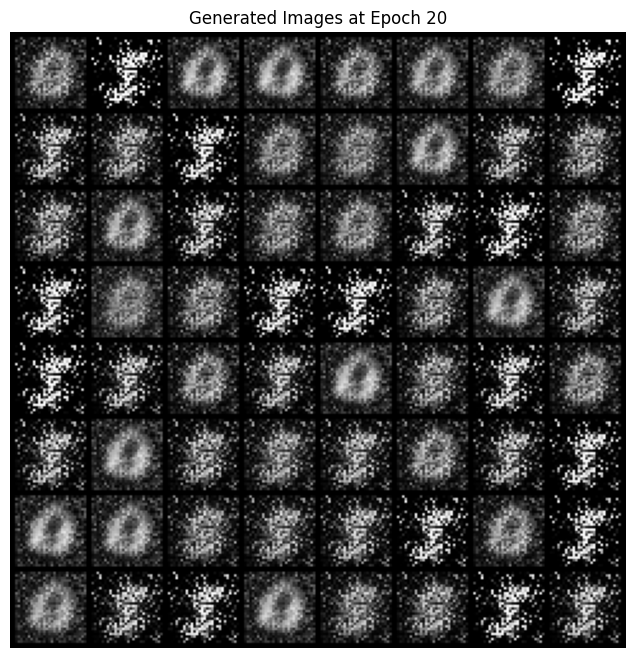

Epoch [30/50], D_loss: 0.5142, G_loss: 3.4952


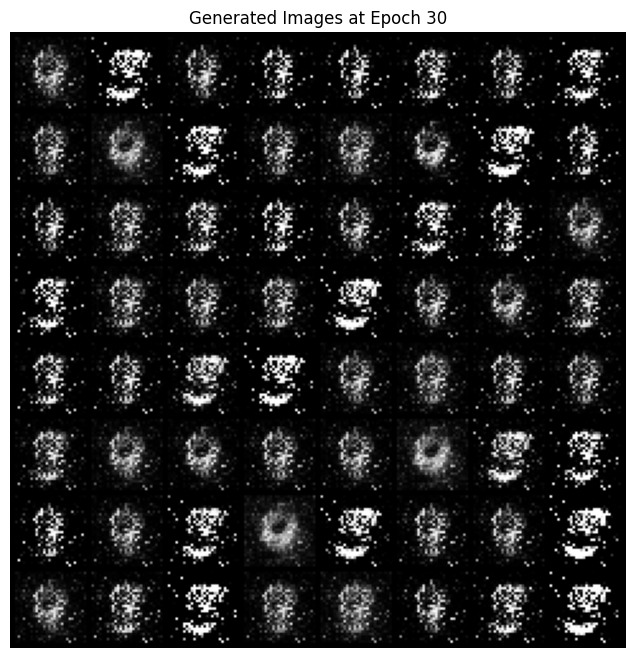

Epoch [40/50], D_loss: 0.8904, G_loss: 6.0542


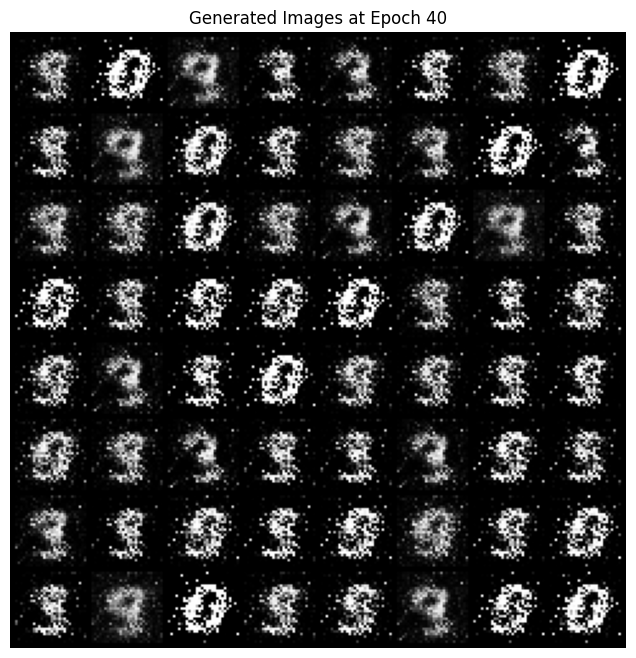

Epoch [50/50], D_loss: 0.4257, G_loss: 3.0643


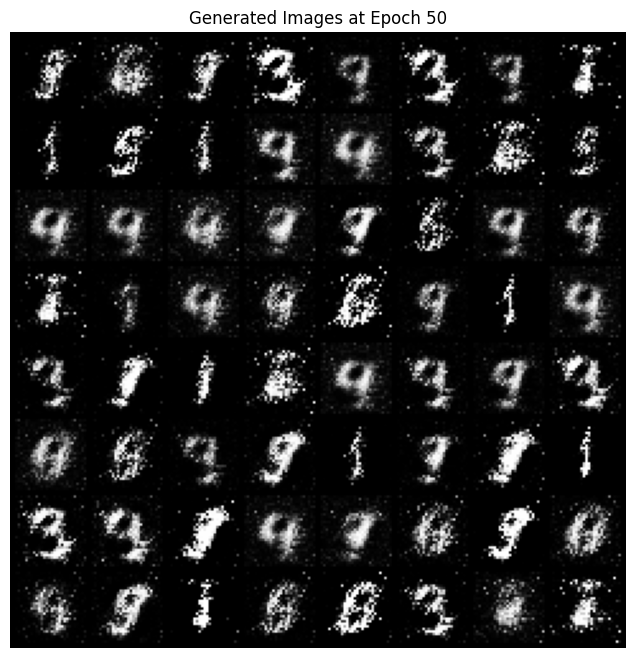

In [19]:
print('Training: 1-step Gen, 1-step Disc')
train_gen(train_loader, num_epochs=50, mode="one_one")

## The Big Picture: The Cop and the Counterfeiter Analogy
Before diving into the code, let's understand the core idea. A GAN has two competing neural networks:

### The Generator (The Counterfeiter 🎨):
Its job is to create fake, counterfeit money (in our case, images). It starts by making terrible fakes but wants to get so good that its creations are indistinguishable from real money.

### The Discriminator (The Cop 👮):
Its job is to be a detective and identify which money is real and which is fake. It starts as a rookie but learns over time to become an expert at spotting fakes.

They train together in a cat-and-mouse game. The counterfeiter gets feedback on why its fakes were caught and improves. The cop sees better and better fakes and gets better at detecting them. The ultimate goal is for the Generator to become so good that the Discriminator is fooled about 50% of the time, meaning it can't tell the difference anymore. At that point, the Generator can create realistic images.

### 1. The Generator Class
This class defines the "Counterfeiter" network.


```python
class Generator(nn.Module):
  def __init__(self, noise_dim, img_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(...)

  def forward(self, z):
    return self.model(z)
```
class Generator(nn.Module):: Defines our Generator. It inherits from nn.Module, which is the base class for all neural network models in PyTorch. This gives it all the necessary functionality, like tracking its layers and parameters.

__init__(self, noise_dim, img_dim):: The constructor.

noise_dim: The size of the input random noise vector (e.g., 100). This is the "seed" or "inspiration" the Generator uses to create a unique image.

img_dim: The size of the output image (e.g., 28*28 = 784 pixels).

self.model = nn.Sequential(...): This is the core of the Generator. We use nn.Sequential, a container that neatly stacks layers. The data will flow through these layers in the order they are defined.

nn.Linear(noise_dim, 256): A fully connected layer that takes the input noise vector of size 100 and transforms it into a vector of size 256.

nn.ReLU(True): An activation function. It introduces non-linearity, allowing the network to learn more complex patterns. It basically changes all negative values to zero.

nn.Linear(256, 512), nn.ReLU(True), nn.Linear(512, 1024), nn.ReLU(True): More layers that progressively expand the vector, learning more intricate features at each step.

nn.Linear(1024, img_dim): The final layer that transforms the 1024-dimensional vector into the desired output image size (784).

nn.Tanh(): The final activation function. It squashes all output values to be between -1 and 1. This is a crucial choice because the real images are also normalized to be in this same range. This makes the Generator's job easier, as it's trying to produce values in the same scale as the real data.

forward(self, z):: This method defines what happens when you pass data through the generator.

z: The input noise tensor.

return self.model(z): It simply passes the noise z through the sequential model and returns the output—a flattened, generated image.

### 2. The Discriminator Class
This class defines the "Cop" network.

```python
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(...)

  def forward(self, img):
    return self.model(img)
```
__init__(self, img_dim):: The constructor takes the img_dim because its job is to analyze an image (real or fake) of that size.

self.model = nn.Sequential(...): The architecture of the detective.

nn.Linear(img_dim, 512): Takes the flattened input image (784 pixels) and transforms it into a 512-dimensional vector.

nn.LeakyReLU(0.2, inplace=True): A slightly different activation function. Unlike ReLU, it allows a small, non-zero gradient for negative inputs. This often helps prevent "dying ReLU" problems and is a common choice in GANs.

nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True): More layers that progressively shrink the vector, trying to distill the image's features down to a single prediction.

nn.Linear(256, 1): The final layer. It condenses all the learned features into a single number (a logit).

nn.Sigmoid(): The final activation function. It takes the single number from the previous layer and squashes it to a value between 0 and 1. This is interpreted as a probability. A value close to 1 means "I think this image is real," and a value close to 0 means "I think this image is fake."

forward(self, img):: Defines the forward pass. It takes an image img, passes it through the sequential model, and returns the probability score (a single value between 0 and 1).

### 3. Initialization and Setup
```python
noise_dim = 100
img_dim = 28*28

generator = Generator(noise_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=0.002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)

criterion = nn.BCELoss()
```
noise_dim, img_dim: Setting up the dimensions we discussed.

generator = ..., discriminator = ...: Creating instances (actual objects) of our two models. .to(device) moves them to the GPU for faster training if available.

g_optimizer, d_optimizer: We need two separate optimizers. Adam is a popular and effective choice. g_optimizer is responsible for updating only the Generator's weights, and d_optimizer updates only the Discriminator's weights.

criterion = nn.BCELoss(): We choose Binary Cross-Entropy Loss. This loss function is perfect for our task because the Discriminator outputs a probability (between 0 and 1). BCELoss measures the error in a binary (0 or 1) prediction task.

### 4. The train_gen Function (The Training Loop)
This is where the magic happens. The two networks are pitted against each other.

```python
for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(train_loader):
```
This is a standard PyTorch training loop. We loop for a number of epochs (full passes over the dataset), and in each epoch, we loop through the data in batches.

### **Part 1: Train the Discriminator**
The goal here is to teach the Discriminator to get better at telling real from fake.

```python
# Real images
outputs = discriminator(real)
d_loss_real = criterion(outputs, real_labels)
```
We take a batch of real images from our dataset.

We pass them to the discriminator.

We calculate the loss (d_loss_real) by comparing the discriminator's outputs to a tensor of all ones (real_labels). **We are teaching it: "When you see these images, you should output 1."**

```python
# Fake images
z = torch.randn(batch_size, noise_dim).to(device)
fake = generator(z)
outputs = discriminator(fake.detach())
d_loss_fake = criterion(outputs, fake_labels)
```
We generate a batch of random noise z.

We pass the noise to the generator to create a batch of fake images.

We pass these fake images to the discriminator.

**fake.detach() is VERY important. **When we train the discriminator, we only want to update its weights, not the generator's. .detach() creates a copy of the fake tensor that is "detached" from the generator's computation graph. This means when we call d_loss.backward(), the gradients will not flow back into the generator.

We calculate the loss (d_loss_fake) by comparing the discriminator's outputs to a tensor of all zeros (fake_labels). **We are teaching it: "When you see these images, you should output 0."**

```python
d_loss = d_loss_real + d_loss_fake
discriminator.zero_grad()
d_loss.backward()
d_optimizer.step()
```

The total discriminator loss d_loss is the sum of its mistakes on real and fake images.

We perform the standard optimization steps: clear old gradients (zero_grad), compute new gradients (backward), and update the discriminator's weights (step).

### **Part 2: Train the Generator**
Now, we hold the discriminator constant and teach the generator to get better at fooling it.

```python
# Generate fake images again
z = torch.randn(batch_size, noise_dim).to(device)
fake = generator(z)
outputs = discriminator(fake)

g_loss = criterion(outputs, real_labels) # trick discriminator
```
We generate a new batch of fake images.

We pass them through the discriminator. Note that this time we do not use .detach(), because we want the gradients to flow all the way back to the generator to train it.

This is the clever trick: We calculate the generator's loss g_loss by comparing the discriminator's outputs to real_labels (a tensor of all ones). The generator's goal is to make the discriminator output 1 for its fake images. So, **we are telling the generator: "Your goal is to produce images that the The discriminator will classify it as real.** The loss is how far you are from achieving that goal."

```pyhon
generator.zero_grad()
g_loss.backward()
g_optimizer.step()
```
We perform the optimization steps for the generator: clear its old gradients, compute new gradients (which flow from the discriminator's output back through the generator's layers), and update the generator's weights.

